### Refining quadrilateral and hexahedral element meshes
https://gitlab.onelab.info/gmsh/gmsh/-/issues/1381

https://stackoverflow.com/questions/65726076/plotting-data-on-a-hexagonal-figure

Remove duplicate points:

https://gitlab.onelab.info/gmsh/gmsh/-/issues/983


In [10]:
import gmsh
import numpy as np

cl = 9
cg = (0, 0)
DIM = 2

In [ ]:
def get_square_points(square):
    _, adjancecies_down = gmsh.model.getAdjacencies(DIM, square)
    _, pt_tags_adj_down = gmsh.model.getAdjacencies(DIM - 1, adjancecies_down[2])
    return pt_tags_adj_down

def add_line_between_squares(square_0_pts, square_1_pts):
    line_0_0 = gmsh.model.occ.addLine(startTag=square_0_pts[0], endTag=square_1_pts[0])
    line_0_1 = gmsh.model.occ.addLine(startTag=square_0_pts[1], endTag=square_1_pts[1])
    return line_0_0, line_0_1

def add_refinement_connectivity(square_0, square_1, squares_n2, squares_n22):
    square_0_pts = get_square_points(square_0)
    square_1_pts = get_square_points(square_1)
    
    line_0_1, line_0_2 = add_line_between_squares(square_0_pts, square_1_pts)

    squares_n2_pts = np.empty((len(squares_n2), 2), dtype=int)
    for i, square in enumerate(squares_n2):
        pt_tags_adj_down = get_square_points(square)
        squares_n2_pts[i] = pt_tags_adj_down

    squares_n22_pts = np.empty((len(squares_n22), 2), dtype=int)
    for i, square in enumerate(squares_n22):
        pt_tags_adj_down = get_square_points(square)
        squares_n22_pts[i] = pt_tags_adj_down


    lines_connectors = np.empty((len(squares_n2), 2), dtype=int)
    for i in range(3):
        line_0_1, line_0_2 = add_line_between_squares(squares_n2_pts[i], squares_n22_pts[i])
        lines_connectors[i] = [line_0_1, line_0_2]
    gmsh.model.occ.synchronize()
    return lines_connectors

def create_square_geom(cg, cl):
    square_0 = gmsh.model.occ.addRectangle(cg[0] - cl/2, cg[1] - cl/2, 0, cl, cl)
    square_1 = gmsh.model.occ.addRectangle(cg[0] - cl/6, cg[1] - cl/6, 0, cl/3, cl/3)


    square_11 = gmsh.model.occ.addRectangle(cg[0] - cl/2, cg[1] - cl/2, 0, cl/3, cl/3)
    square_12 = gmsh.model.occ.addRectangle(cg[0] - cl/6, cg[1] - cl/2, 0, cl/3, cl/3)
    square_13 = gmsh.model.occ.addRectangle(cg[0] + cl/6, cg[1] - cl/2, 0, cl/3, cl/3)
    squares_n2 = [square_11, square_12, square_13]

    square_111 = gmsh.model.occ.addRectangle(cg[0] - cl/2, cg[1] - cl/2, 0, cl/9, cl/9)
    square_112 = gmsh.model.occ.addRectangle(cg[0] - 3.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)
    square_113 = gmsh.model.occ.addRectangle(cg[0] - 2.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)

    square_211 = gmsh.model.occ.addRectangle(cg[0] - cl/6, cg[1] - cl/2, 0, cl/9, cl/9)
    square_212 = gmsh.model.occ.addRectangle(cg[0] - 0.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)
    square_213 = gmsh.model.occ.addRectangle(cg[0] + 0.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)

    square_311 = gmsh.model.occ.addRectangle(cg[0] + cl/6, cg[1] - cl/2, 0, cl/9, cl/9)
    square_312 = gmsh.model.occ.addRectangle(cg[0] + 2.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)
    square_313 = gmsh.model.occ.addRectangle(cg[0] + 3.5 * cl/9, cg[1] - cl/2, 0, cl/9, cl/9)

    square_122 = gmsh.model.occ.addRectangle(cg[0] - 3.5 * cl/9, cg[1] - 3.5 * cl/9, 0, cl/9, cl/9)
    square_222 = gmsh.model.occ.addRectangle(cg[0] - 0.5 * cl/9, cg[1] - 3.5 * cl/9, 0, cl/9, cl/9)
    square_322 = gmsh.model.occ.addRectangle(cg[0] + 2.5 * cl/9, cg[1] - 3.5 * cl/9, 0, cl/9, cl/9)
    squares_n22 = [square_122, square_222, square_322]
    return square_0, square_1, squares_n2, squares_n22

def remove_square_curves():
    for curve in gmsh.model.getEntities(1):
        gmsh.model.occ.remove([curve])
    gmsh.model.occ.synchronize()

def remove_square_surfaces():
    for plane in gmsh.model.getEntities(2):
        gmsh.model.occ.remove([plane])
    gmsh.model.occ.synchronize()

In [ ]:
# Create a mesh of a square
gmsh.initialize()

# create base geometry
square_0, square_1, squares_n2, squares_n22 = create_square_geom(cg, cl)
gmsh.model.occ.synchronize()
# add refinement connectivity to decrease the mesh size
lines_connectors = add_refinement_connectivity(square_0, square_1, squares_n2, squares_n22)
remove_square_surfaces()
remove_square_curves()

# for line in gmsh.model.getEntities(1):
#     gmsh.model.mesh.setTransfiniteCurve(line[1], 1)
# for surf in gmsh.model.getEntities(2):
#     gmsh.model.mesh.setTransfiniteSurface(surf[1])
# gmsh.model.mesh.setRecombine(2, 1)
# gmsh.model.mesh.generate(2)
gmsh.write("../../../99_testing_prototyping/square.geo_unrolled")
gmsh.fltk.run()
gmsh.finalize()

# check square.geo ;)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
cl = 3
cg = (0, 0)

In [13]:
# * SINGLE CENTERED SQUARE FUNCTION
def create_square(cg, cl):
    return np.array([[cg[0] - cl/2, cg[1] - cl/2],
                     [cg[0] - cl/2, cg[1] + cl/2],
                     [cg[0] + cl/2, cg[1] + cl/2],
                     [cg[0] + cl/2, cg[1] - cl/2]])

square_center = create_square(cg, cl)
square_bottom = create_square((cg[0], cg[1] - cl), cl)
square_n1 = create_square((cg[0], cg[1] - 4*cl/3), cl/3)
square_n1_bottom = create_square((cg[0], cg[1] - 5*cl/3), cl/3)
square_n11 = create_square((cg[0], cg[1] - 16*cl/9), cl/9)
square_n11_bottom = create_square((cg[0], cg[1] - 17*cl/9), cl/9)

In [14]:
# * MULTIPLE INLINE SQUARES FUNCTION

def sort_trab_ccw(squares_unique_coords):
    squares_center = np.mean(squares_unique_coords, axis=0)
    squares_ccw_idx = np.argsort(np.arctan2(squares_unique_coords[:, 1] - squares_center[1], squares_unique_coords[:, 0] - squares_center[0]))
    return squares_unique_coords[squares_ccw_idx]

def gmsh_add_points(squares_ccw_sort):
    points = np.empty(np.shape(squares_ccw_sort))
    for i, point in enumerate(squares_ccw_sort):
        point_tags = gmsh.model.occ.addPoint(point[0], point[1], 0)
        points[i] = point_tags
    return points
    
def gmsh_create_lines(points):
    print(points)
    lines = []
    for i in range(len(points) - 1):
        print(f'point1 = {points[i]}, point2 = {points[i+1]}')
        # line_tags = gmsh.model.occ.addLine(points[i], points[i+1])
        # lines.append(line_tags)
    return lines

def create_squares_m(cg, cl, n_squares, _dir):
    squares = []
    if _dir == 'vertical':
        for i in range(n_squares):
            center_x = cg[0] + (i - (n_squares - 1)/2) * cl
            square = np.array([[center_x - cl/2, cg[1] - cl/2],
                               [center_x - cl/2, cg[1] + cl/2],
                               [center_x + cl/2, cg[1] + cl/2],
                               [center_x + cl/2, cg[1] - cl/2]])
            squares.append(square)
    
    elif _dir == 'horizontal':
        for i in range(n_squares):
            center_y = cg[1] + (i - (n_squares - 1)/2) * cl
            square = np.array([[cg[0] - cl/2, center_y - cl/2],
                               [cg[0] + cl/2, center_y - cl/2],
                               [cg[0] + cl/2, center_y + cl/2],
                               [cg[0] - cl/2, center_y + cl/2]])
            squares.append(square)
    squares_reshaped = np.array(squares).reshape(-1, 2)
    squares_unique_coords = np.unique(squares_reshaped, axis=0)
    
    # sort points in ccw order
    squares_ccw_sort = sort_trab_ccw(squares_unique_coords)
    point_tags = gmsh_add_points(squares_ccw_sort)
    point_tags = np.array(point_tags, dtype=int)
    point_tags_4 = point_tags.reshape(-1, 4)
    lines = gmsh_create_lines(point_tags_4)
    gmsh.model.occ.synchronize()
    return squares_unique_coords, point_tags

def create_square_directional(cg, cl_i, cl_j):
    cl_t = cl_i + cl_j
    m = 3
    if cl_i == 0:
        _dir_s = 'vertical'
        square_bottom, square_bottom_tags = create_squares_m((cg[0] - cl_i, cg[1] - cl_j), cl_t, 1, _dir=_dir_s)
        square_n1, square_n1_tags = create_squares_m((cg[0] - cl_i, cg[1] - cl_j), cl_t/m, 2*m+1, _dir=_dir_s)
        square_n11, square_n11_tags = create_squares_m((cg[0] - cl_i, cg[1] - (cl_j + cl_j/m)), cl_t/(3*m), 27, _dir=_dir_s)
        square_n11_bottom, square_n11_bottom_tags = create_squares_m((cg[0] - cl_i, cg[1] - (cl_j + cl_j/m + cl_j/(3*m))), cl_t/(3*m), 27, _dir=_dir_s)
    elif cl_j == 0:
        _dir_s = 'horizontal'
        square_bottom, square_bottom_tags = create_squares_m((cg[0] - cl_i, cg[1] - cl_j), cl_t, 1, _dir=_dir_s)
        square_n1, square_n1_tags = create_squares_m((cg[0] - cl_i, cg[1] - cl_j), cl_t/m, 2*m+1, _dir=_dir_s)
        square_n11, square_n11_tags = create_squares_m((cg[0] - (cl_i + cl_i/m), cg[1] - cl_j), cl_t/(3*m), 27, _dir=_dir_s)
        square_n11_bottom, square_n11_bottom_tags = create_squares_m((cg[0] - (cl_i + cl_i/m + cl_i/(3*m)), cg[1] - cl_j), cl_t/(3*m), 27, _dir=_dir_s)
    else:
        raise ValueError("cl_i and cl_j cannot be both different from 0")
    point_coords = np.concatenate((square_bottom, square_n1, square_n11, square_n11_bottom)).tolist()
    point_tags = np.concatenate((square_bottom_tags, square_n1_tags, square_n11_tags, square_n11_bottom_tags)).tolist()
    return point_coords, point_tags

import gmsh
gmsh.initialize()
square_center, square_center_tags = create_squares_m(cg, cl, 1, _dir='horizontal')
square_inf, square_inf_tags = create_square_directional(cg=cg, cl_i=0, cl_j=cl)
square_l = create_square_directional(cg=cg, cl_i=cl, cl_j=0)
square_sup = create_square_directional(cg=cg, cl_i=0, cl_j=-cl)
square_r = create_square_directional(cg=cg, cl_i=-cl, cl_j=0)
gmsh.model.occ.synchronize()
gmsh.fltk.run()
gmsh.finalize()


[[1 1 2 2]
 [3 3 4 4]]
point1 = [1 1 2 2], point2 = [3 3 4 4]
[[5 5 6 6]
 [7 7 8 8]]
point1 = [5 5 6 6], point2 = [7 7 8 8]
[[ 9  9 10 10]
 [11 11 12 12]
 [13 13 14 14]
 [15 15 16 16]
 [17 17 18 18]
 [19 19 20 20]
 [21 21 22 22]
 [23 23 24 24]]
point1 = [ 9  9 10 10], point2 = [11 11 12 12]
point1 = [11 11 12 12], point2 = [13 13 14 14]
point1 = [13 13 14 14], point2 = [15 15 16 16]
point1 = [15 15 16 16], point2 = [17 17 18 18]
point1 = [17 17 18 18], point2 = [19 19 20 20]
point1 = [19 19 20 20], point2 = [21 21 22 22]
point1 = [21 21 22 22], point2 = [23 23 24 24]
[[ 25  25  26  26]
 [ 27  27  28  28]
 [ 29  29  30  30]
 [ 31  31  32  32]
 [ 33  33  34  34]
 [ 35  35  36  36]
 [ 37  37  38  38]
 [ 39  39  40  40]
 [ 41  41  42  42]
 [ 43  43  44  44]
 [ 45  45  46  46]
 [ 47  47  48  48]
 [ 49  49  50  50]
 [ 51  51  52  52]
 [ 53  53  54  54]
 [ 55  55  56  56]
 [ 57  57  58  58]
 [ 59  59  60  60]
 [ 61  61  62  62]
 [ 63  63  64  64]
 [ 65  65  66  66]
 [ 67  67  68  68]
 [ 69  6

TypeError: list indices must be integers or slices, not tuple

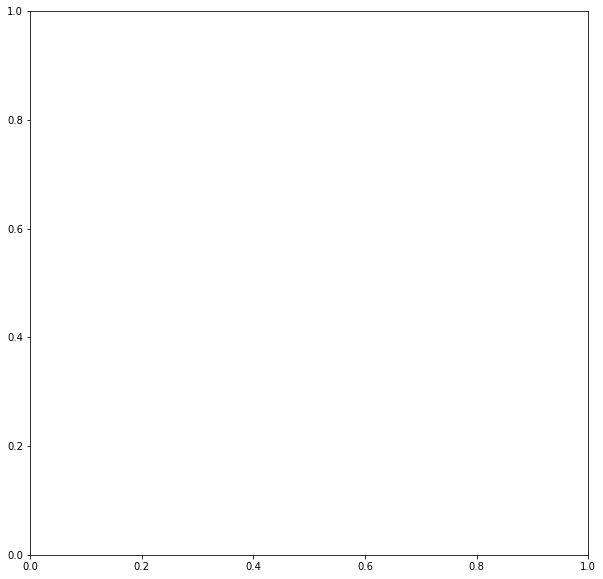

In [15]:
a = 10
fig = plt.figure(figsize=(a, a))
ax = fig.add_subplot(111)
ax.plot(square_inf[:, 0], square_inf[:, 1], 'o', label='square_inf')
ax.plot(square_r[:, 0], square_r[:, 1], 'o', label='square_r')
ax.plot(square_sup[:, 0], square_sup[:, 1], 'o', label='square_sup')
ax.plot(square_l[:, 0], square_l[:, 1], 'o', label='square_l')
ax.plot(square_center[:, 0], square_center[:, 1], 'o', label='square_center')

plt.legend()
ax.set_aspect('equal')

In [16]:
# concatenate all the squares
points = np.concatenate((square_inf, square_r, square_sup, square_l, square_center))
points_unique = np.unique(points, axis=0)

# sort points based on radius from center
points_sorted = points_unique[np.argsort(np.linalg.norm(points_unique - cg, axis=1))]
# sort points_sorted based on angle from center
points_angle_sorted = points_sorted[np.argsort(np.arctan2(points_sorted[:, 1] - cg[1], points_sorted[:, 0] - cg[0]))]

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

[[ 6  2]
 [ 7  3]
 [10  3]
 [10  7]
 [11  6]
 [12  0]
 [13  9]
 [15  3]
 [17  2]
 [17 14]
 [21 13]
 [23  9]
 [23 13]
 [23 18]
 [24  5]
 [25  2]
 [26  3]
 [26 10]
 [26 15]
 [27  5]
 [27 15]
 [27 24]
 [30 20]
 [31  7]
 [31 22]
 [32  4]
 [32 28]
 [33 28]
 [34 20]
 [35 22]
 [36  9]
 [36 34]
 [37  0]
 [38 16]
 [38 20]
 [38 30]
 [39 18]
 [40 18]
 [40 39]
 [41 18]
 [41 39]
 [42 13]
 [42 21]
 [43 24]
 [43 32]
 [44 11]
 [44 14]
 [45  9]
 [45 23]
 [45 36]
 [46 10]
 [46 37]
 [47 21]
 [47 24]
 [48  1]
 [48 33]
 [49 25]
 [50  1]
 [50 43]
 [51 15]
 [51 26]
 [51 40]
 [52  9]
 [52 13]
 [52 16]
 [52 21]
 [52 38]
 [53  4]
 [53 24]
 [53 32]
 [53 43]
 [53 47]
 [54 18]
 [54 23]
 [54 45]
 [54 49]
 [55  9]
 [55 20]
 [55 34]
 [55 36]
 [55 38]
 [55 52]
 [56  4]
 [56 32]
 [57  2]
 [57  6]
 [57 11]
 [57 14]
 [57 17]
 [57 44]
 [58  5]
 [58 29]
 [59 28]
 [59 33]
 [59 48]
 [60  0]
 [60  7]
 [60 22]
 [60 31]
 [61  3]
 [61 29]
 [61 58]
 [62 10]
 [62 39]
 [62 46]
 [63  2]
 [63  6]
 [63 25]
 [63 34]
 [63 49]
 [64 39]
 

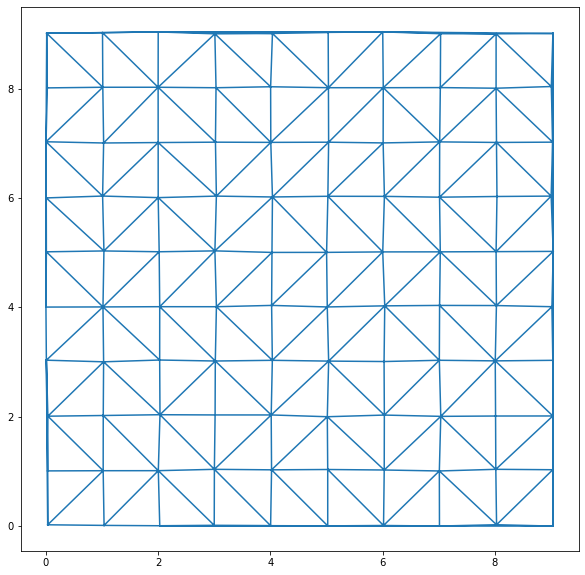

In [19]:
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import random

# x, y = points[:, 0], points[:, 1]
x,y = np.meshgrid(np.arange(10), np.arange(10))
x = x.flatten()
y = y.flatten()
coordinates = np.column_stack([x,y])+0.04 * np.random.rand(len(x), 2)
np.random.shuffle(coordinates)
x=coordinates[:,0]
y=coordinates[:,1]

# perform triangulation
triang=tri.Triangulation(x,y)
f = plt.figure(figsize=(10,10))
ax = plt.axes()
tri.triplot(ax,triang)

In [ ]:
# Apply affine transform to mesh
# https://math.stackexchange.com/questions/2005847/affine-transformation-of-square

import gmsh
mesh_path = r'/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/99_testing_prototyping/square_2.msh'

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add('Surface_Mesh_Generation')
gmsh.open(mesh_path)

t = [1.2, 0.3, 0, 0,
     0.5, 0.4, 0, 0,
     0, 0, 1, 0]
gmsh.model.mesh.affineTransform(t)
gmsh.fltk.run()
gmsh.finalize()

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

Transformation matrix:
[[-0.3  0.3  0. ]
 [-0.2 -0.2  0. ]]

Transformed quad1:
 [ 5.9604645e-08  3.0000000e+00 -5.9604645e-08 -3.0000000e+00
  5.9604645e-08]


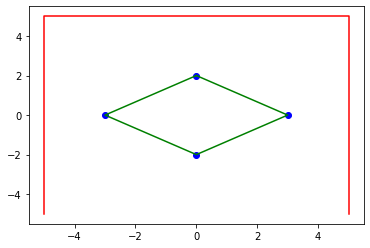

Info    : Increasing process stack size (8192 kB < 16 MB)
Info    : Reading '/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/99_testing_prototyping/square_2.msh'...
Info    : 3451 entities
Info    : 1912 nodes
Info    : 7999 elements
Info    : Done reading '/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/99_testing_prototyping/square_2.msh'
-------------------------------------------------------
Version       : 4.10.5
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220701
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zli

In [1]:
# * MAIN IDEA:
# 1. leggo i 4 punti che compongono il quadrato della regione trabecolare già creata in gmsh
# 2. Calcolo una matrice di trasformazione affine in rispetto ad un quadrato unitario di riferimento
# 3. Applico la matrice di trasformazione affine ai punti del quadrato (una funzione esterna che crea in bottom-up i punti e le relazioni con linee superfici e volumi)
# 4. Inserisco le entità 0D-1D-2D-3D all'interno del quadrato della regione trabecolare così che i riferimenti e le relazioni siano manenute in modo coerente
# 5. Mi assicuro che la superficie esterna (trabecolare_v e trabecolare_h) sia composta da linee transfinite di modo da garantire continuità tra le due fasi (magari servirà una sorta di "ghost layer" per garantire la continuità)
# 6. Creo la mesh come prima, tutto allo stesso tempo (trab+cort)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import gmsh
mesh_path = r'/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/99_testing_prototyping/square_2.msh'

# Define the vertices of the two quadrilaterals
quad1 = np.array([[-5, -5], [-5, 5], [5, 5], [5, -5]], dtype=np.float32)
# quad2 = np.array([[-5, -5], [-5, 5], [5, 5], [5, -5]], dtype=np.float32)
quad2 = np.array([[0, 2], [3, 0], [0, -2], [-3, 0]], dtype=np.float32)
print(quad1.flags)

# Find the perspective transformation matrix
# M = cv2.getPerspectiveTransform(quad1, quad2)
M = cv2.getAffineTransform(quad1[:3], quad2[:3])
print(f"Transformation matrix:\n{M}\n")

# Apply the transformation to quad1
transformed_quad1 = cv2.transform(np.array([quad1]), M)
# append first point to close the polygon #! only as example
transformed_quad1_closed = np.append(transformed_quad1[0], transformed_quad1[0][0]).reshape(-1, 2)

print("Transformed quad1:\n", transformed_quad1_closed[:, 0])

plt.plot(quad1[:, 0], quad1[:, 1], color='red')
plt.scatter(quad2[:, 0], quad2[:, 1], color='blue')
plt.plot(transformed_quad1_closed[:, 0], transformed_quad1_closed[:, 1], color='green')
plt.show()


gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add('Surface_Mesh_Generation')
gmsh.open(mesh_path)

t = [M[0][0], M[0][1], M[0][2], 0,
     M[1][0], M[1][1], M[1][2], 0,
     0, 0, 1, 0]

gmsh.model.mesh.affineTransform(t)
gmsh.fltk.run()
gmsh.finalize()

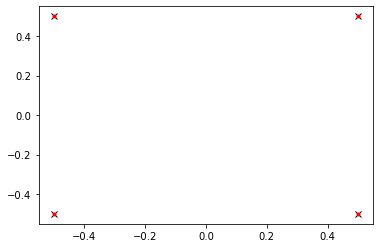

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def create_square_grid(big_square_size, squares_per_side, origin):
    # Calculate the size of each small square
    small_square_size = big_square_size / squares_per_side

    vertices = []
    for i in range(squares_per_side+1):
        for j in range(squares_per_side+1):
            # Calculate the coordinates of the square's top-left corner
            x_s_1 = float(i * small_square_size)
            y_s_1 = float(j * small_square_size)
            vertices.append([x_s_1, y_s_1])

    # center vertices to origing
    vert_max_x = max(vertices, key=lambda x: x[0])[0]
    vert_max_y = max(vertices, key=lambda x: x[1])[1]
    vertices_s = [np.array(v) - np.array([vert_max_x / 2, vert_max_y / 2]) for v in vertices]
    # shift vertices to origin
    vertices = [np.array(v) + np.array(origin) for v in vertices_s]
    return vertices

# Define the size of the big square and the number of squares per side
origin = np.array([0, 0])
square_size_0 = 1
squares_per_side_1 = 1
squares_per_side_2 = squares_per_side_1 ** 2

vertices_1 = create_square_grid(square_size_0, squares_per_side_1, origin)
vertices_2 = create_square_grid(square_size_0, squares_per_side_2, origin)


plt.plot(figsize=(5, 5))
plt.plot([v[0] for v in vertices_1], [v[1] for v in vertices_1], 'x', color='black')
plt.plot([v[0] for v in vertices_2], [v[1] for v in vertices_2], '.', color='red')
plt.show()

In [6]:
# * EXTRACT PATCHES
# https://stackoverflow.com/questions/31527755/extract-blocks-or-patches-from-numpy-array

import numpy as np
from skimage.util import view_as_blocks

a = np.array([[1,5,9,13],
              [2,6,10,14],
              [3,7,11,15],
              [4,8,12,16]])


a = np.array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20, 21, 22],
       [23, 24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58],
       [59, 60, 61, 62, 63, 64, 65, 66, 67],
       [68, 69, 70, 71, 72, 73, 74, 75, 76],
       [77, 78, 79, 80, 81, 82, 83, 84, 85]])

a_blocks = view_as_blocks(a, (3, 3))
print(a_blocks)

[[[[ 5  6  7]
   [14 15 16]
   [23 24 25]]

  [[ 8  9 10]
   [17 18 19]
   [26 27 28]]

  [[11 12 13]
   [20 21 22]
   [29 30 31]]]


 [[[32 33 34]
   [41 42 43]
   [50 51 52]]

  [[35 36 37]
   [44 45 46]
   [53 54 55]]

  [[38 39 40]
   [47 48 49]
   [56 57 58]]]


 [[[59 60 61]
   [68 69 70]
   [77 78 79]]

  [[62 63 64]
   [71 72 73]
   [80 81 82]]

  [[65 66 67]
   [74 75 76]
   [83 84 85]]]]
